In [2]:
# Jesse Galef
# Using data scraped from C-SPAN's uncorrected closed caption transcripts


In [15]:
import pandas as pd
import numpy as np

In [16]:
import re

In [17]:
from bs4 import BeautifulSoup
import urllib

In [18]:
from scipy.sparse import csr_matrix, hstack, diags
from scipy.stats import skew, kurtosis

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.grid_search import GridSearchCV 
from sklearn.cross_validation import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_selection import SelectPercentile, SelectFromModel, SelectKBest, chi2, f_classif


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

In [4]:
# from spacy.en import English
# from spacy import attrs
# nlp_toolkit = English()

In [5]:
from nltk.tokenize import sent_tokenize, word_tokenize
# NLTK's sent_tokenize looks more accurate than Spacy's, and I only need to run it once
from nltk.corpus import stopwords
stops = list(stopwords.words('english'))

In [6]:
from textblob import TextBlob
# 

# Common Words Lists

In [7]:
conjunctions = [u'and',u'that',u'but',u'or',u'as',u'if',u'when',u'than',u'because',
                u'while',u'where',u'after',u'so',u'though',u'since',u'until',u'whether',
                u'before',u'although',u'nor',u'like',u'once',u'unless',u'now',u'except']

In [8]:
pronouns = [u"all", u"another", u"any", u"anybody", u"anyone", u"anything", u"both", u"each", u"each other",
            u"either", u"everybody", u"everyone", u"everything", u"few", u"he", u"her", u"hers",
            u"herself", u"him", u"himself", u"his", u"i", u"it", u"its", u"itself", u"little",
            u"many", u"me", u"mine", u"more", u"most", u"much", u"my", u"myself", u"neither", 
            u"no one", u"nobody", u"none", u"nothing", u"one", u"one another", u"other", u"others",
            u"our", u"ours", u"ourselves", u"several", u"she", u"some", u"somebody", u"someone",
            u"something", u"that", u"their", u"theirs", u"them", u"themselves", u"these", u"they",
            u"this", u"those", u"us", u"we", u"what", u"whatever", u"which", u"whichever", u"who",
            u"whoever", u"whom", u"whomever", u"whose", u"you", u"your", u"yours", u"yourself", u"yourselves"]

# Transformer classes and Functions

In [9]:

def pipeline_features(step):
    # Passed a pipeline or pipeline step, recursively checks each named 
    # step and builds a list of features.
    # This returns the list in the same order that the estimator uses
    # In retrospect, this is only useful when the pipeline is feature union, and 
    # took extra work to handle any true pipelines with one component feeding into another
    
    features = []
    if type(step)==Pipeline:
        for named_step in step.named_steps:
            features = features + pipeline_features(step.named_steps[named_step])
    elif type(step) == FeatureUnion:
        for transformer in step.transformer_list:
            features = features + pipeline_features(transformer[1])
    elif (type(step) == LogisticRegression or (type(step) == MultinomialNB)):
        features = []
    else:
        features = step.get_feature_names()
    return features


In [10]:
def pipeline_coef_df(pipeline):
    # Passed a pipeline with estimator, creates a DataFrame of the coeficients for each class
    
    feature_list = pipeline_features(pipeline)
    if len(pipeline.named_steps['classifier'].classes_) == 2:
        coef_df = pd.DataFrame(pipeline.named_steps['classifier'].coef_, 
                           index = [pipeline.named_steps['classifier'].classes_[1]],
                           columns=feature_list).transpose()
        coef_df[pipeline.named_steps['classifier'].classes_[0]] = -coef_df[pipeline.named_steps['classifier'].classes_[1]]
    else:
        coef_df = pd.DataFrame(pipeline.named_steps['classifier'].coef_, 
                           index = pipeline.named_steps['classifier'].classes_, 
                           columns=feature_list).transpose()
    return np.e**(coef_df) # To get the odds ratios rather than the log odds


In [11]:
class word_length(TransformerMixin, BaseEstimator):
    # very quick calculation of the number ad distribution of words of different lengths
    
    def __init__(self):
        pass

    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        info = []
        for sentence in X:
            row = {}
            tokens = [len(t) for t in re.findall(regex_token_pattern, sentence)]
            row['avg_word_length'] = sum(tokens)/float(len(tokens))
            row['num_words'] = len(tokens)
            row['num_words_sqrt'] = len(tokens)**.5
            info.append(row)
        return pd.DataFrame(info)
    
    def get_feature_names(self):
        return ['avg_word_length', 'num_words', 'num_words_sqrt']
    

In [12]:
class best_vectorizer(TransformerMixin, BaseEstimator):
    # Transformer that takes a vectorizer and sklearn selector (like SelectKBest or SelectPercentile)
    # to find the n best features
    
    def __init__(self, vectorizer, selector, name):
        self.vectorizer=vectorizer
        self.selector=selector
        self.name = name
    
    def fit(self, X, y, **fit_params):
        vectors = self.vectorizer.fit_transform(X)
        self.selector.fit(vectors, y)
        return self

    def transform(self, X, **transform_params):
        return self.selector.transform(self.vectorizer.transform(X))
    
    def get_feature_names(self):
        return [self.name+feature for feature, used in zip(self.vectorizer.get_feature_names(), self.selector.get_support()) if used==True]
    
    

In [13]:


class sentiments(TransformerMixin, BaseEstimator):
    # Uses the Textblob library to evaluate the sentiment polarity & subjectivity of each sentence,
    # and returns the result of the passed vectorizer fit/transform multipied by polarity and subjectivity
    # For example, if a sentence is -.8 polarity and uses the term 'Obama', it will return 
    # -.8 as the value of polarity_obama
    
    # Returns csr sparse matrix
    
    def __init__(self, vectorizer):
        self.vectorizer = vectorizer
    
    def fit(self, X, y=None):
        self.vectorizer.fit(X)
        return self
    
    def transform(self, X):
        sent_vectors = self.vectorizer.transform(X)
        polarities = []
        subjectivities = []
        for sentence in X:
            polarity, subjectivity = TextBlob(sentence).sentiment
            polarities.append(polarity)
            subjectivities.append(subjectivity)
            
        p_diag = diags(polarities,0)
        s_diag = diags(subjectivities,0)
        polarity_vectors = p_diag.dot(sent_vectors)
        subjectivity_vectors = s_diag.dot(sent_vectors)
        return hstack([polarity_vectors,subjectivity_vectors])
    
    def get_feature_names(self):
        return ['polarity_'+i for i in self.vectorizer.get_feature_names()]+['subjectivity_'+i for i in self.vectorizer.get_feature_names()]


# Start reading data

In [19]:
republicans = ['Trump']#,'Cruz','Kasich','Rubio','Bush']
democrats = ['Clinton']#,'Sanders']
# Most of the infrastructure is here to include more than two candidates

long_df = pd.DataFrame()
for candidate in republicans+democrats:
    long_df = long_df.append(pd.read_csv(candidate+"_transcript_df.csv",index_col=0),ignore_index=True)

In [20]:
long_df.shape

(215, 6)

In [21]:
long_df.speaker.value_counts()

Trump      112
Clinton    103
Name: speaker, dtype: int64

In [22]:
regex_token_pattern = "\\b[\\w\']+\\b"

In [23]:
%%time
sentence_list = []
for idx, speech in long_df.iterrows():
    raw = unicode(speech.text,errors='ignore').lower().replace('\r','').replace('  ',' ').replace('>','').replace('w3','').replace(' v ','')
    #Fixing a few known glitches in the C-SPAN transcribing service
    sentences = sent_tokenize(raw)
    for sentence in sentences:
        sent_info = {}
        sent_info['sentence'] = sentence
        sent_info['speaker'] = speech.speaker
        sent_info['date'] = speech.date
        sent_info['title'] = speech.title
        sent_info['speech_idx'] = idx
        sent_info['tokens'] = len(re.findall(regex_token_pattern, sentence))
        sentence_list.append(sent_info)
raw_df = pd.DataFrame(sentence_list)

CPU times: user 10 s, sys: 218 ms, total: 10.2 s
Wall time: 10.2 s


In [24]:
raw_df.speaker.value_counts()

Trump      47110
Clinton    20041
Name: speaker, dtype: int64

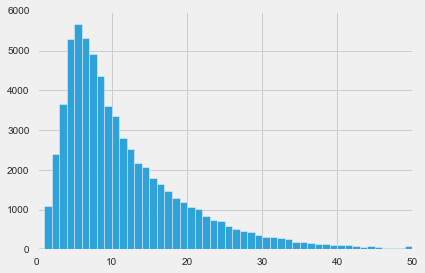

In [25]:
raw_df[raw_df.tokens <=50].tokens.hist(bins=50)
# plt.xlim([0,50])

In [26]:
declarations = {}
declarations['Trump'] = '2015-06-16'
declarations['Clinton'] = '2015-04-11'
# Although C-SPAN has the campaign tag, I want to make sure only to include
# events from after the candidates officially declared they were running for President

In [27]:

for i in range(20):
    print i, len(raw_df[raw_df.tokens>=i])/float(len(raw_df))

0 1.0
1 0.999508570237
2 0.982993551846
3 0.947282989084
4 0.892600259118
5 0.813867254397
6 0.729371118822
7 0.650295602448
8 0.577176810472
9 0.512278298164
10 0.458474185046
11 0.408616401841
12 0.366710845706
13 0.328915429405
14 0.29645128144
15 0.26540185552
16 0.238507244866
17 0.213876189483
18 0.192029902756
19 0.172715223898


In order to avoid sentences like "Thank you." which are indistinguishable, I'm only using
sentences with a certain number of tokens. 
Sometimes the uncorrected transcripts include long run-on sentences and song lyrics, so I'm also ignoring any sentences with more than 150 words.

In [28]:
min_length = 9
max_length = 150
df = raw_df[raw_df.tokens >= min_length]
df = df[df.tokens <= max_length]
post_dec = [date > dec for date,dec in zip(df.date, [declarations[candidate] for candidate in df.speaker])]
df = df[post_dec]

In [29]:
df.speaker.value_counts()

Trump      20446
Clinton    13662
Name: speaker, dtype: int64

In [30]:
max(df.speaker.value_counts())/float(len(df))

0.59944880966342207

# Data In, configure Pipeline

In [31]:

vectorizer = CountVectorizer(
                         ngram_range=(1,3), 
                         decode_error='ignore',
                         binary=True,
                        token_pattern = regex_token_pattern,
                            )

    

In [32]:
pipeline = Pipeline([
  ('features', FeatureUnion([
#                     ('word_lengths', word_length()),
                    ('top_words', best_vectorizer(vectorizer, selector=SelectFromModel(estimator=LogisticRegression(penalty='l1', C=25, class_weight='balanced')), name='')),
                ])),
    ('classifier', LogisticRegression(C=1,class_weight = 'balanced', fit_intercept=False))]
)
# Because I ended up using only one transformer/feature, a lot of the infrastructure seems unnecessary
# but if/when I want to add more complexity, it's there to be used.

# Cross Validate to set hyperparameters

In [33]:
which_candidates = ['Clinton','Trump']

In [34]:
from sklearn.cross_validation import cross_val_score
import time

In [222]:
#  class sklearn.linear_model.LogisticRegression(penalty='l2', dual=False, 
# tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, 
# random_state=None, solver='liblinear', max_iter=100, multi_class='ovr', verbose=0, 
# warm_start=False, n_jobs=1)[source]

In [35]:
t0=time.time()

condition = [speaker in which_candidates for speaker in df.speaker]
cand_df = df[condition]
kf = StratifiedKFold(y=cand_df.speaker, n_folds=3,random_state=42)
params = {'classifier__C': [.3,1,3,6],
#           'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
#           'features__top_words__vectorizer__min_df': [1,5],
#           'features__top_words__vectorizer__max_df': [.5,.25],
#           'features__top_words__selector__estimator__penalty': ['l1','l2],
#           'features__top_words__vectorizer__binary': [True, False],
          'features__top_words__selector': [
        SelectFromModel(LogisticRegression(penalty='l1', C=3)),
        SelectFromModel(LogisticRegression(penalty='l1', C=10)),
        SelectFromModel(LogisticRegression(penalty='l1', C=30)),

    ]
         }

grid = GridSearchCV(estimator=pipeline, param_grid = params, scoring = 'roc_auc',cv=kf, verbose=2)

grid.fit(cand_df.sentence,[1 if speaker == 'Trump' else 0 for speaker in cand_df.speaker])
print time.time()-t0
#

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] classifier__C=0.3, features__top_words__selector=SelectFromModel(estimator=LogisticRegression(C=3, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
        prefit=False, threshold=None) 
[CV]  classifier__C=0.3, features__top_words__selector=SelectFromModel(estimator=LogisticRegression(C=3, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
        prefit=False, threshold=None) -  11.1s
[CV] classifier__C=0.3, features__top_words__selector=SelectFromModel(estimator=LogisticRegression(C=3, class_weight=None, dual=False, fit_intercept=True,
         

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  7.9min finished


491.460838795


In [36]:
scores = grid.grid_scores_
grid.best_params_

{'classifier__C': 1,
 'features__top_words__selector': SelectFromModel(estimator=LogisticRegression(C=30, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
         prefit=False, threshold=None)}

In [37]:
cv = []
scores = grid.grid_scores_
for combo in scores:
    pars = combo[0]
    pars['mean'] = combo[1]
    cv.append(pars)
pd.DataFrame(cv).sort_values(by='mean',ascending=False)

,classifier__C,features__top_words__selector,mean
5,1.0,SelectFromModel(estimator=LogisticRegression(C...,0.886529
4,1.0,SelectFromModel(estimator=LogisticRegression(C...,0.886471
3,1.0,SelectFromModel(estimator=LogisticRegression(C...,0.886347
1,0.3,SelectFromModel(estimator=LogisticRegression(C...,0.885855
2,0.3,SelectFromModel(estimator=LogisticRegression(C...,0.885851
0,0.3,SelectFromModel(estimator=LogisticRegression(C...,0.885836
8,3.0,SelectFromModel(estimator=LogisticRegression(C...,0.884919
7,3.0,SelectFromModel(estimator=LogisticRegression(C...,0.884827
6,3.0,SelectFromModel(estimator=LogisticRegression(C...,0.884100
11,6.0,SelectFromModel(estimator=LogisticRegression(C...,0.883643


## Build a cross-val-predict-proba

In [38]:
pipeline=grid.best_estimator_

In [39]:
import time

cand_df = df[[speaker in which_candidates for speaker in df.speaker]]

n_folds = 20

segment_results = pd.DataFrame()
all_results = pd.DataFrame()
segment_coefs = [pd.DataFrame()]*n_folds

kf = StratifiedKFold(y=cand_df.speaker, n_folds =n_folds,random_state=42)

for i, (train_index, test_index) in enumerate(kf):
    t0 = time.time()
    pipeline.fit(cand_df.iloc[train_index].sentence, cand_df.iloc[train_index].speaker)
#     print 'done fitting',i,"time:",time.time()-t0
    segment_coefs[i] = pipeline_coef_df(pipeline)
    segment_results = pd.DataFrame(
                                    pipeline.predict_proba(cand_df.iloc[test_index].sentence),
                                    index=list(cand_df.iloc[test_index].index),
                                    columns=pipeline.named_steps['classifier'].classes_)
    print 'done predicting',i,"time:",time.time()-t0

    all_results=all_results.append(segment_results)
        
    

done predicting 0 time: 20.2192239761
done predicting 1 time: 19.4864919186
done predicting 2 time: 19.8765630722
done predicting 3 time: 19.9900529385
done predicting 4 time: 19.8697199821
done predicting 5 time: 20.6659529209
done predicting 6 time: 20.223788023
done predicting 7 time: 19.8693478107
done predicting 8 time: 19.6816358566
done predicting 9 time: 19.9817211628
done predicting 10 time: 20.3159661293
done predicting 11 time: 20.001376152
done predicting 12 time: 19.9472329617
done predicting 13 time: 21.0529270172
done predicting 14 time: 19.7490339279
done predicting 15 time: 19.6028687954
done predicting 16 time: 19.8822329044
done predicting 17 time: 19.9356639385
done predicting 18 time: 19.7197599411
done predicting 19 time: 19.9417769909


In [40]:
cv_result = cand_df.copy().join(all_results)

In [41]:
cv_result.groupby('speaker').mean()

,speech_idx,tokens,Clinton,Trump
speaker,,,,
Clinton,163.725589,19.783560,0.780687,0.219313
Trump,54.335176,16.538443,0.188163,0.811837


In [42]:
cv_result['predict'] = cv_result.apply(lambda x: x[which_candidates].argmax(), axis = 1)

In [43]:
cv_result['correct'] = cv_result.predict == cv_result.speaker

In [44]:
cv_result.correct.value_counts()

True     28923
False     5185
Name: correct, dtype: int64

In [45]:
cv_result.correct.mean()

0.84798287791720417

0.922870444726


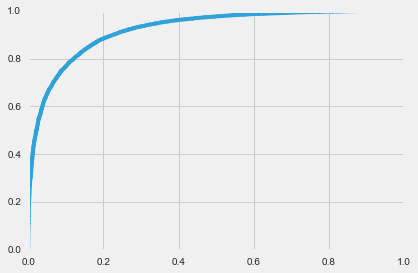

In [46]:
#  sklearn.metrics.roc_curve(y_true, y_score, pos_label=None, sample_weight=None, drop_intermediate
correct= [1 if speaker == 'Trump' else 0 for speaker in cv_result.speaker]
roc = roc_curve(correct, y_score=list(cv_result.Trump))
print roc_auc_score(correct, cv_result.Trump)
plt.plot(roc[0], roc[1])

([<matplotlib.axis.XTick at 0x13e96ea50>,
 <a list of 6 Text xticklabel objects>)

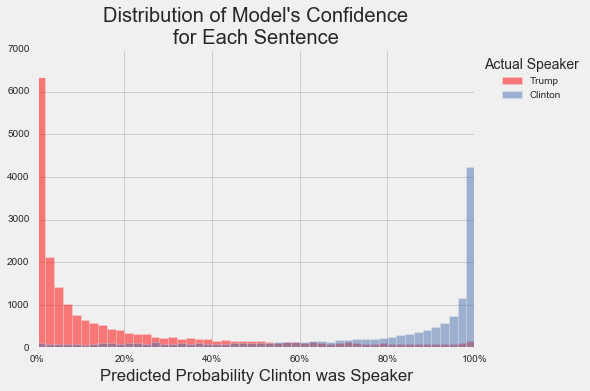

In [267]:
f = plt.figure(figsize=[7,5])
ax = plt.gca()
sns.distplot(cv_result[cv_result.speaker == 'Trump'].Clinton, ax=ax, kde=False, bins=50, color='red', hist_kws={'alpha':.5}, label='Trump')
sns.distplot(cv_result[cv_result.speaker == 'Clinton'].Clinton, ax=ax, kde=False, bins=50, hist_kws={'alpha':.5}, label='Clinton')
plt.xlim([0,1])
# plt.yticks([1000,2000,3000,4000,5000,6000])
ax.legend(title='Actual Speaker', loc='upper left', bbox_to_anchor=(1,1))
plt.xlabel('Predicted Probability Clinton was Speaker')
plt.title("Distribution of Model's Confidence\nfor Each Sentence")
plt.xticks(np.arange(0,1.1,.2), ['0%','20%','40%','60%','80%','100%'])
# f.tight_layout(h_pad=.5)


# g = sns.lmplot("x", "y", col="c", data=df)
# g.fig.suptitle("Title of the plot", size=16)
# t.subplots_adjust(top=1.1)

In [47]:
sns.set_palette('deep')

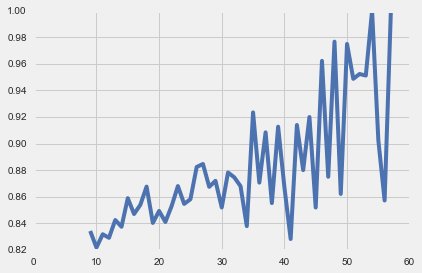

In [48]:
plt.plot(cv_result[(cv_result.tokens <=60)&(cv_result.tokens >=2)].groupby('tokens').mean()['correct'])

In [49]:
cv_result.head()

,date,sentence,speaker,speech_idx,title,tokens,Clinton,Trump,predict,correct
1,2016-10-17,now we are live at the convention center this ...,Trump,0,"Donald Trump Campaign Event in Green Bay, Wisc...",21,0.127171,0.872829,Trump,True
3,2016-10-17,"we want, to start by thanking the fire marshal.",Trump,0,"Donald Trump Campaign Event in Green Bay, Wisc...",9,0.631376,0.368624,Clinton,False
5,2016-10-17,in 22 days we will win the state of wisconsin.,Trump,0,"Donald Trump Campaign Event in Green Bay, Wisc...",10,0.009321,0.990679,Trump,True
8,2016-10-17,we're up in the ohio and we are doing great.,Trump,0,"Donald Trump Campaign Event in Green Bay, Wisc...",10,0.029117,0.970883,Trump,True
10,2016-10-17,together we will deliver real change to put am...,Trump,0,"Donald Trump Campaign Event in Green Bay, Wisc...",10,0.471013,0.528987,Trump,True


In [268]:
long_df.link.to_csv('speech_links.csv', header=True, index_label='idx')

In [51]:
cv_result.shape

(34108, 10)

In [52]:

for candidate in which_candidates:
    print "Most",candidate,":"
    for idx, row in cv_result[cv_result.speaker == cv_result.predict].sort_values(by=candidate,ascending=False).iloc[0:10].iterrows():
        sent = row.sentence
        print "\t",sent[0].upper()+sent[1:]
        print "--",row.speech_idx, row.title
        print long_df.loc[row.speech_idx].link
        print "Predicted Clinton: ",row.Clinton
        print "Predicted Trump: ",row.Trump
        print
    print
    print
    

Most Clinton :
	That's why the slogan of my campaign is stronger together  because i think if we work  together and overcome the  divisiveness that sometimes  sets americans against one  another and instead we make  some big goals and i've set  forth some big goals, getting the economy to work for  everyone, not just those at the top, making sure we have the best education system from  preschool through college and making it affordable and somp  else.
-- 112 Presidential Candidates Debate
http://www.c-span.org/video/?414227-1/presidential-nominees-debate-washington-university
Predicted Clinton:  0.99999999999
Predicted Trump:  1.04761466567e-11

	I hope you will join me and that you will be part of this effort to build on the progress we have made under president obama to go further and to make it absolutely clear that we are fighting to break down barriers wherever they may be because we know america deserves nothing less and americans deserve to have the future that we will create to

In [53]:
cv_result.sort_values('Trump', inplace=True)

In [54]:
cv_result.to_csv('cv_result_oct18.csv')
cv_result.to_csv('cv_result.csv')

In [55]:

for candidate in which_candidates:
    print "Most",candidate+"-like, but not:"
    for idx, row in cv_result[cv_result.speaker != cv_result.predict].sort_values(by=candidate,ascending=False).iloc[0:10].iterrows():
        sent = row.sentence
        print "\t",sent[0].upper()+sent[1:]
        print "--",row.speech_idx, row.title
        print long_df.loc[row.speech_idx].link
        print "Predicted Clinton: ",row.Clinton
        print "Predicted Trump: ",row.Trump
        print
    print
    print

Most Clinton-like, but not:
	For example, one victory we did have late last year, we passed the bill in the house and the senate to repeal obamacare completely.
-- 37 Faith and Freedom Coalition Conference
http://www.c-span.org/video/?410912-1/faith-freedom-coalition-holds-annual-conference
Predicted Clinton:  0.999933944642
Predicted Trump:  6.60553575782e-05

	This is why we have already  passed legislation to support  wounded warriors, veterans who  struggle with mental health challenges and earlier this week to support female veterans in  particular who need our help.
-- 37 Faith and Freedom Coalition Conference
http://www.c-span.org/video/?410912-1/faith-freedom-coalition-holds-annual-conference
Predicted Clinton:  0.999925846791
Predicted Trump:  7.41532093799e-05

	Our whole country loses when young people of limitless potential are denied the opportunity to contribute their talents because we failed to provide them the opportunities that they deserve.
-- 20 Donald Trump Campaig

In [56]:
sums = {}
for candidate in which_candidates:
    sums[candidate] = pd.DataFrame(index=segment_coefs[0].index)
t0 = time.time()
for i, segment in enumerate(segment_coefs):
    segment.drop_duplicates(inplace=True)
    for candidate in which_candidates:
        sums[candidate] = sums[candidate].join(segment[candidate], rsuffix=str(i))
        sums[candidate].drop_duplicates(inplace=True)


In [57]:
average_coef = pd.DataFrame()

for candidate in which_candidates:
    sums[candidate].fillna(1.0, inplace=True) # odds ratio
    #     average_coef[candidate] = sums[candidate].apply(lambda x: len(x) / sum([1./i for i in x]), axis=1)
    logged = np.log(sums[candidate])
    average_coef[candidate] = np.e**(logged.sum(axis=1) /  logged.shape[1])

In [277]:
print (average_coef.sort_values(by='Trump', ascending=False).head(30)['Trump']*100).astype(int)/100
print
print (average_coef.sort_values(by='Trump', ascending=True).head(30)['Clinton']*100).astype(int)/100

tremendous       14.57
guy              10.25
media             8.60
does it           8.24
hillary           8.15
politicians       8.00
almost            7.83
incredible        7.42
illegal           7.16
general           7.03
frankly           6.97
border            6.89
establishment     6.84
jeb               6.76
allowed           6.72
obama             6.48
poll              6.24
by the way        6.21
bernie            6.20
ivanka            6.09
japan             5.98
politician        5.96
nice              5.93
conservative      5.90
islamic           5.77
hispanics         5.76
deals             5.47
win               5.43
guys              5.34
believe me        5.32
Name: Trump, dtype: float64

my husband            12.95
recession             10.28
attention              9.72
wall street            9.44
grateful               9.23
or us                  8.39
citizens united        7.97
mother                 7.20
something else         7.17
strategy               7.05
c

In [59]:
average_coef.sort_values('Trump', inplace=True)
average_coef.to_csv('average_coef_oct_18.csv')
average_coef.to_csv('average_coef.csv')

In [60]:

def color_map(percent, top, bottom):
    if percent >1:
        percent = 1
    diff = [t-b for t,b in zip(top, bottom)]
    
    return [(d*percent)+b for d,b in zip(diff, bottom)]
    

In [61]:
pronoun_coefs = average_coef.loc[[col for col in average_coef.index if col in pronouns]].sort_values('Trump', ascending=False)
# toplot = pronoun_coefs[((pronoun_coefs.Trump >= 1.5) | (pronoun_coefs.Clinton >=1.5))].copy()
toplot = pronoun_coefs.iloc[0:15].append(pronoun_coefs.iloc[-15:])


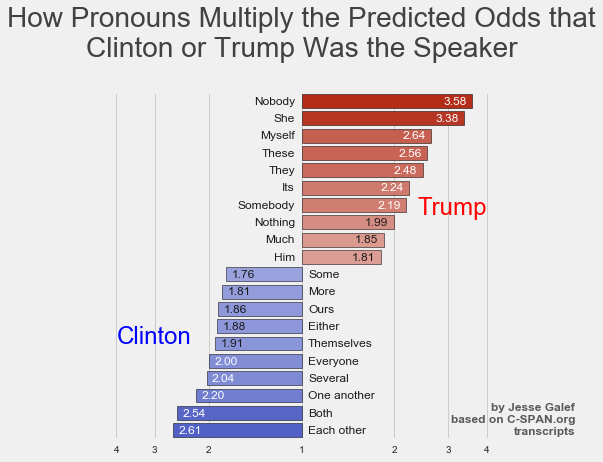

In [260]:
pronoun_coefs = average_coef.loc[[col for col in average_coef.index if col in pronouns]].sort_values('Trump', ascending=False)
# toplot = pronoun_coefs[((pronoun_coefs.Trump >= 1.5) | (pronoun_coefs.Clinton >=1.5))].copy()
toplot = pronoun_coefs.iloc[0:10].append(pronoun_coefs.iloc[-10:])

f, (ax1) = plt.subplots(1,1, figsize=(8,7))
label_size = 12
value_size = 9

vals = [np.log(x) for x in toplot.sort_values('Trump', ascending=False).Trump]

#minimum=abs(min(vals))
maximum=max(vals)
minimum=maximum
blue=[0,.1,.8]
red = [.8,.1,0]
white = [1,1,1]
colors = [color_map(-value/minimum, blue, white) if value < 0 else color_map(value/maximum, red, white) for value in vals]


sns.barplot(x=vals,
            y=toplot.sort_values('Trump', ascending=False).index, ax=ax1,
            palette=colors, 
#             color=colors,
            edgecolor='black')

ax1.set_title("How Pronouns Multiply the Predicted Odds that\nClinton or Trump Was the Speaker\n", fontsize=28, color=[.25,.25,.25])

# ax1.set_yticklabels([x[0].upper()+x[1:] for x in toplot.sort_values('Trump', ascending=False).index.values], fontsize=16)


labels = [x[0].upper()+x[1:] for x in toplot.sort_values('Trump', ascending=False).index.values]
for i, patch in enumerate(ax1.patches):
    width = patch.get_width()
    
    if patch.get_x() < 0:
        # Bars extending on the left
        label_x = .05
        label_halign = 'left'
        if patch.get_width() >= np.log(1.15):     
            value_x = patch.get_x()+.04
            value_halign = 'left'
        else:
            value_x = patch.get_x()-.04
            value_halign='right'
    else:
        # Bars extending on the right
        label_x = -.05
        label_halign = 'right'
        if patch.get_width() >= np.log(1.15):
            value_x = patch.get_width()-.04
            value_halign = 'right'
        else:
            value_x = patch.get_width() + .04
            value_halign = 'left'

    value_color = [.1,.1,.1]
    if patch.get_width()> np.log(2): value_color = 'white'
    ax1.text(label_x, patch.get_y()+.61, '%s'%(labels[i]), color=[.1,.1,.1], ha=label_halign, fontsize=label_size)   
    ax1.text(value_x, patch.get_y()+.61, '%1.2f'%(np.e**abs(vals[i])), color=value_color, ha=value_halign, fontsize=label_size)    

ax1.text(-np.log(4), 14, 'Clinton', color='b', fontsize=24)
ax1.text(np.log(4), 6.6, 'Trump', color='r', fontsize=24, ha='right')

ax1.set_yticklabels([])
ax1.set_xlabel('')
ax1.set_xlim([-np.log(5),np.log(5)])

ax1.set_xticks([-np.log(4),-np.log(3),-np.log(2),0,np.log(2),np.log(3), np.log(4)], minor=False)
ax1.set_xticklabels([4,3,2,1,2,3,4], minor=False)

f.text(.95, .07, 'by Jesse Galef\nbased on C-SPAN.org\ntranscripts', color=[.2,.2,.2], fontsize=12, alpha=.8, ha='right', weight='bold', variant='small-caps')


plt.plot()
f.tight_layout(rect=[0,0,.95,.95])

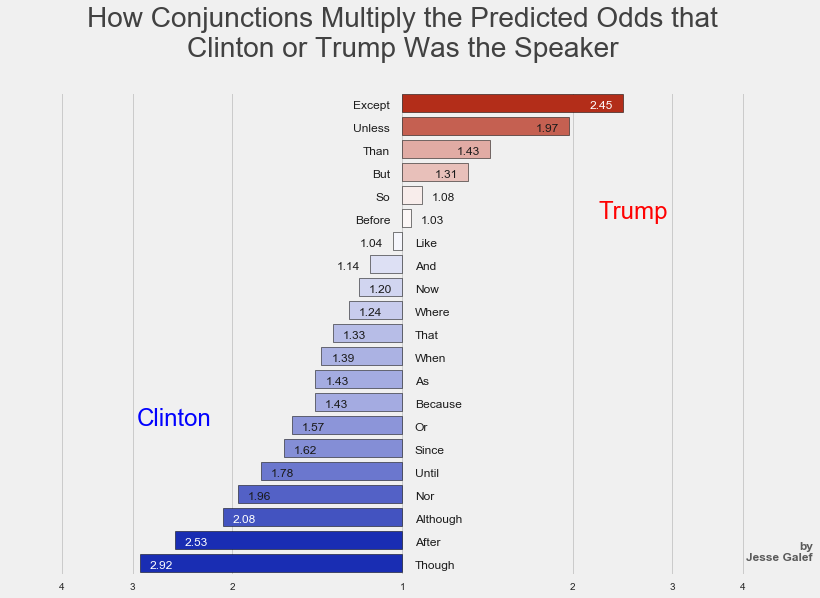

In [63]:
conj_coefs = average_coef.loc[[col for col in average_coef.index if col in conjunctions]].sort_values('Trump', ascending=False)
# toplot = pronoun_coefs[((pronoun_coefs.Truzmp >= 1.5) | (pronoun_coefs.Clinton >=1.5))].copy()
# toplot = conj_coefs.iloc[0:10].append(conj_coefs.iloc[-10:])
toplot = conj_coefs

f, (ax1) = plt.subplots(1,1, figsize=(12,9))
label_size = 12
value_size = 9

vals = [np.log(x) for x in toplot.sort_values('Trump', ascending=False).Trump]

#minimum=abs(min(vals))
maximum=max(vals)
minimum=maximum
blue=[0,.1,.8]
red = [.8,.1,0]
white = [1,1,1]
colors = [color_map(-value/minimum, blue, white) if value < 0 else color_map(value/maximum, red, white) for value in vals]


sns.barplot(x=vals,
            y=toplot.sort_values('Trump', ascending=False).index, ax=ax1,
            palette=colors, 
#             color=colors,
            edgecolor='black')

ax1.set_title("How Conjunctions Multiply the Predicted Odds that\nClinton or Trump Was the Speaker\n", fontsize=28, color=[.25,.25,.25])

# ax1.set_yticklabels([x[0].upper()+x[1:] for x in toplot.sort_values('Trump', ascending=False).index.values], fontsize=16)


labels = [x[0].upper()+x[1:] for x in toplot.sort_values('Trump', ascending=False).index.values]
for i, patch in enumerate(ax1.patches):
    width = patch.get_width()
    
    if patch.get_x() < 0:
        # Bars extending on the left
        label_x = .05
        label_halign = 'left'
        if patch.get_width() >= np.log(1.15):     
            value_x = patch.get_x()+.04
            value_halign = 'left'
        else:
            value_x = patch.get_x()-.04
            value_halign='right'
    else:
        # Bars extending on the right
        label_x = -.05
        label_halign = 'right'
        if patch.get_width() >= np.log(1.15):
            value_x = patch.get_width()-.04
            value_halign = 'right'
        else:
            value_x = patch.get_width() + .04
            value_halign = 'left'

    value_color = [.1,.1,.1]
    if patch.get_width()> np.log(2): value_color = 'white'
    ax1.text(label_x, patch.get_y()+.61, '%s'%(labels[i]), color=[.1,.1,.1], ha=label_halign, fontsize=label_size)   
    ax1.text(value_x, patch.get_y()+.61, '%1.2f'%(np.e**abs(vals[i])), color=value_color, ha=value_halign, fontsize=label_size)    

ax1.text(-np.log(2.95), 14, 'Clinton', color='b', fontsize=24)
ax1.text(np.log(2.95), 5, 'Trump', color='r', fontsize=24, ha='right')

ax1.set_yticklabels([])
ax1.set_xlabel('')
ax1.set_xlim([-np.log(5),np.log(5)])

ax1.set_xticks([-np.log(4),-np.log(3),-np.log(2),0,np.log(2),np.log(3), np.log(4)], minor=False)
ax1.set_xticklabels([4,3,2,1,2,3,4], minor=False)

f.text(.95, .07, 'by\nJesse Galef', color=[.2,.2,.2], fontsize=12, alpha=.8, ha='right', weight='bold', variant='small-caps')


plt.plot()
f.tight_layout(rect=[0,0,.95,.95])

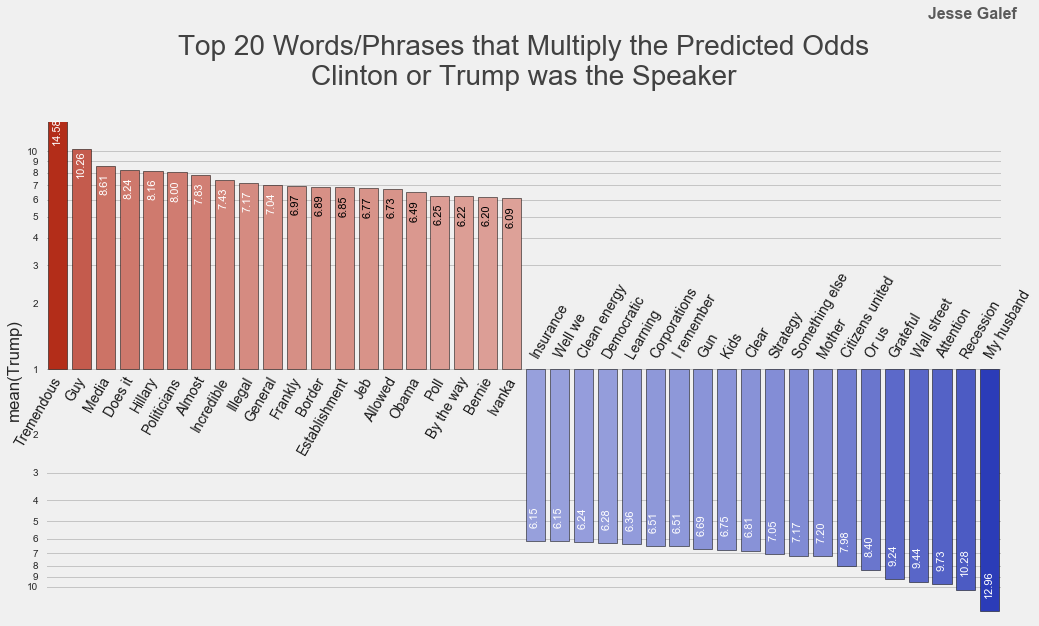

In [294]:
#  seaborn.barplot(x=None, y=None, hue=None, data=None, order=None, hue_order=None, 
#  estimator=<function mean>, ci=95, n_boot=1000, units=None, orient=None, color=None,
#  palette=None, saturation=0.75, errcolor='.26', errwidth=None, capsize=None, ax=None, **kwargs)¶
f, ax1 = plt.subplots(1,1, figsize=(15,9))

ax1.set_yticks([-1*np.log(x) for x in range(10,1,-1)]+[0]+[np.log(y) for y in range(2,11)])
    
ax1.set_yticklabels(range(10,1,-1)+['1']+range(2,11))


ax1.set_ylabel('')

label_font_size = 14
value_font_size=11
rotate =60
n_words = 20

color_adjustment = np.log(3)
val_series = average_coef.sort_values('Trump', ascending=False)['Trump']
vals = val_series[:n_words].append(val_series[-n_words:])
vals = np.log(vals)

# minimum=abs(min(vals))
maximum=max(vals)
minimum=maximum
blue=[0,.1,.8]
red = [.8,.1,0]
white = [1,1,1]

colors = [color_map(-(value+color_adjustment)/(minimum-color_adjustment), blue, white) if value < 0 else color_map((value-color_adjustment)/(maximum-color_adjustment), red, white) for value in vals]

sns.barplot(y=vals,
            x=vals.index, ax=ax1,
            palette=colors, 
#             color=colors,
            edgecolor='black')

ax1.set_xticks([])
ax1.set_xlabel('')
ax1.set_title("Top "+str(n_words)+" Words/Phrases that Multiply the Predicted Odds\nClinton or Trump was the Speaker\n", fontsize=28, color=[.25,.25,.25])


labels = [x[0].upper()+x[1:] for x in vals.sort_values(ascending=False).index.values]

for i, patch in enumerate(ax1.patches):
    height = patch.get_height()
    if patch.get_y() < 0:
#         y = patch.get_y() -.5
        if height > np.log(6): 
            color = 'white'
        else:
            color = 'black'

        ax1.text(patch.get_x()+.1, .1, '%s'%(labels[i]), color=[.1,.1,.1], va='bottom', ha='left', rotation=rotate, fontsize=label_font_size)
        ax1.text(patch.get_x()+.15, patch.get_y()+.15, '%1.2f'%(np.e**abs(vals[i])), color=color, rotation=90, va='bottom', fontsize=value_font_size)
    else:
        if height > np.log(7): 
            color = 'white'
        else:
            color = 'black'
        ax1.text(patch.get_x()+.7, -.05, '%s'%(labels[i]), color=[.1,.1,.1], ha='right', va='top', rotation=rotate, fontsize=label_font_size)
        ax1.text(patch.get_x()+.15, patch.get_y()+height-.3, '%1.2f'%(np.e**abs(vals[i])), color=color, rotation = 90, va='bottom', fontsize=value_font_size)

            
f.text(.95, .95, 'Jesse Galef', color=[.2,.2,.2], fontsize=16, alpha=.8, ha='right', weight='bold', variant='small-caps')

ax1.set_ylim([-np.log(14), np.log(14)])

# ax1.yaxis.tick_right()
# ax1.yaxis.set_ticks_position('both')

for i, ygrid in enumerate(ax1.get_ygridlines()):
#     print ygrid.get_ydata(orig=False)[0], np.log(2)
#     if abs(ygrid.get_ydata(orig=True)[0]) == np.log(2):
    if i==8 or i==10:
        ygrid.set_xdata([0,0])

plt.grid(which='major', color=[.7,.7,.7], alpha=.7)
plt.margins(.3)
plt.plot()
f.tight_layout(rect=[0,0,.95,.95])



In [257]:
cv_result.shape

(34108, 10)

In [298]:
word = 'bush'
# word_in_term = [word in re.findall(regex_token_pattern,term) for term in average_coef.index]
word_in_term = [word in term for term in average_coef.index]

average_coef[word_in_term]

,Clinton,Trump
the bush,2.764533,0.361725
and jeb bush,1.105872,0.904264
george w bush,1.099748,0.909299
bush administration,1.026241,0.974430
than george bush,0.984305,1.015945


In [284]:
%%time
long_diff = []
for first_term in average_coef.index:
    for word in first_term.split():
        if len(word)>=5:
            overlap_list = [term for term in average_coef.index if (word in term and first_term!=term)]
            for overlap in overlap_list:
                term1_odds = average_coef.loc[first_term].Clinton
                overlap_odds = average_coef.loc[overlap].Clinton
                if np.log(term1_odds)*np.log(overlap_odds) <0: # If the terms indicate opposite candidates
                    long_diff.append([first_term, overlap, term1_odds,overlap_odds, term1_odds/overlap_odds])


CPU times: user 1min 17s, sys: 1.58 s, total: 1min 19s
Wall time: 1min 19s


In [285]:
len(over)

37031

In [286]:
over = pd.DataFrame(long_diff, columns=['Term1', 'Term2','Term1_Clinton','Term2_Clinton', 'Mult'])

In [287]:
over.head()

,Term1,Term2,Term1_Clinton,Term2_Clinton,Mult
0,citizens united,citizens and,7.979482,0.863269,9.243327
1,citizens united,citizens,7.979482,0.627167,12.723057
2,citizens united,citizens of the,7.979482,0.621886,12.831108
3,citizens united,the united nations,7.979482,0.837879,9.523426
4,citizens united,with the united,7.979482,0.822779,9.698205


In [288]:
over.sort_values('Mult').to_csv('overlaps.csv')

In [290]:
over.sort_values('Mult').iloc[40:80]

,Term1,Term2,Term1_Clinton,Term2_Clinton,Mult
70928,american public,republicans,0.392638,5.508586,0.071277
72600,people that,of people who,0.280710,3.931817,0.071394
72854,is president,president elect,0.273321,3.775788,0.072388
73171,those people,33 000 people,0.218814,2.996447,0.073024
70335,just about the,about what,0.418374,5.687802,0.073556
73358,hillary,called hillarycare,0.122555,1.661645,0.073755
73337,obama,obamacare it was,0.154191,2.089551,0.073792
72724,have a president,president elect,0.278701,3.775788,0.073813
70237,about it,about what,0.419863,5.687802,0.073818
73265,talking about,about what's,0.205026,2.750879,0.074531


array([<matplotlib.axes._subplots.AxesSubplot object at 0x132860750>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x12eef8650>], dtype=object)

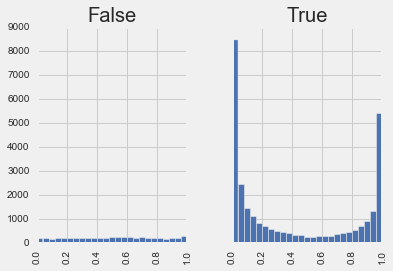

In [70]:
cv_result.hist(column='Clinton', by='correct', bins=25, sharey=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x132df1650>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x132829950>], dtype=object)

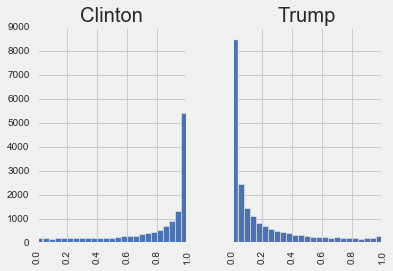

In [192]:
cv_result.hist(column='Clinton', by='speaker', bins=25, sharey=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1234ab3d0>]], dtype=object)

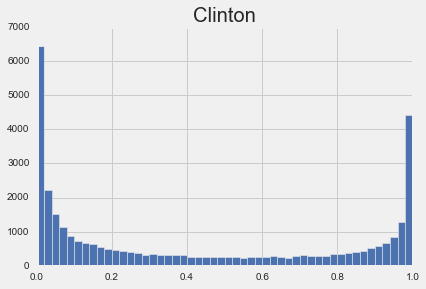

In [69]:
cv_result.hist('Clinton', bins=50)

In [73]:
sept26_avg = pd.read_csv('average_coef_sept_26.csv', index_col=0)

In [74]:
sept26_avg.head()

,Clinton,Trump
my husband,11.322642,0.088319
wall street,10.150987,0.098513
attention,9.384565,0.106558
opportunities,7.990501,0.125149
or us,7.890791,0.126730


In [75]:
average_coef.head()

,Clinton,Trump
my husband,12.955692,0.077186
recession,10.280219,0.097274
attention,9.729840,0.102777
wall street,9.441752,0.105913
grateful,9.236325,0.108268


In [76]:
?df.join

In [107]:
diff = sept26_avg.join(average_coef, lsuffix='_sept26', rsuffix='_oct18')

In [111]:
# What are the most previously important terms are no longer top terms?
print diff[diff.isnull().any(axis=1)].sort_values('Clinton_sept26').head(20)[[0,1]]
print diff[diff.isnull().any(axis=1)].sort_values('Clinton_sept26').tail(20)[[0,1]]

             Clinton_sept26  Trump_sept26
last night         0.352648      2.835687
head of            0.388590      2.573404
lobbyists          0.393809      2.539302
we go              0.398462      2.509647
you like           0.415840      2.404774
bottom             0.446202      2.241137
to believe         0.453671      2.204242
you saw            0.458654      2.180291
south korea        0.470558      2.125137
and replace        0.471725      2.119880
million and        0.484860      2.062452
peace              0.494069      2.024010
ladies             0.496136      2.015577
in the u           0.508249      1.967538
get the job        0.527601      1.895372
we pray            0.527893      1.894323
know and           0.530257      1.885877
alabama            0.531417      1.881762
him that           0.532818      1.876814
she did            0.534987      1.869204
                Clinton_sept26  Trump_sept26
important that        2.026376      0.493492
risk of               2.0277

In [112]:
diff.dropna(inplace=True)

In [113]:
diff.head()

,Clinton_sept26,Trump_sept26,Clinton_oct18,Trump_oct18
my husband,11.322642,0.088319,12.955692,0.077186
wall street,10.150987,0.098513,9.441752,0.105913
attention,9.384565,0.106558,9.729840,0.102777
opportunities,7.990501,0.125149,4.929094,0.202877
or us,7.890791,0.126730,8.396391,0.119099


In [114]:
diff['Clinton_diff'] = diff.Clinton_oct18 / diff.Clinton_sept26
diff['Trump_diff'] = diff.Trump_oct18 /  diff.Trump_sept26

In [115]:
print diff.sort_values('Clinton_diff').head(20)[[4,5]]
print diff.sort_values('Clinton_diff').tail(20)[[4,5]]

               Clinton_diff  Trump_diff
provide            0.365927    2.732787
gentlemen          0.393274    2.542757
voter              0.396965    2.519114
dollar             0.410148    2.438143
when a             0.448135    2.231468
regulation         0.452155    2.211633
i know it          0.455088    2.197375
me say             0.458911    2.179072
oath               0.462049    2.164272
are better         0.466512    2.143567
accept the         0.468242    2.135648
rates              0.471824    2.119433
part of our        0.476362    2.099243
small              0.479104    2.087229
2008               0.493643    2.025757
prosperity         0.495797    2.016957
getting a          0.496364    2.014649
clinton            0.497901    2.008431
we are better      0.498598    2.005624
policies           0.500848    1.996612
                  Clinton_diff  Trump_diff
you and i             1.978899    0.505331
the bush              1.983704    0.504107
soul                  1.990109 

In [280]:
import pandas as pd
avg = pd.read_csv('average_coef.csv', index_col=0)

In [281]:
avg.head()

,Clinton,Trump
my husband,12.955692,0.077186
recession,10.280219,0.097274
attention,9.729840,0.102777
wall street,9.441752,0.105913
grateful,9.236325,0.108268


In [291]:
avg.loc['bernie']

Clinton    0.161176
Trump      6.204385
Name: bernie, dtype: float64

In [293]:
avg.loc['senator sanders']

Clinton    3.175575
Trump      0.314904
Name: senator sanders, dtype: float64